# Integrated Gradients

Our goal is to understand how a deep learning model makes its decisions by writing the XAI code ourselves. We will implement and compare three fundamental methods: Vanilla Gradients,  Gradient x Input, and Integrated Gradients.
We will use a pre-trained Inception V3 model from PyTorch's torchvision library and a dataset of images. This model was trained on the large ImageNet dataset and can classify images into 1000 categories.

In [1]:
# Load necessary libraries

import utils  # set of helper functions
import torch  # pytorch for deep learning
import numpy as np  # numpy for matrix operations
import matplotlib.pyplot as plt  # matplotlib for plotting
from utils import custom_cmap  # custom color map for visualizing attributions
from captum.attr import (
    LayerGradCam,
    Occlusion,
    IntegratedGradients,
)  # captum built in attribution methods
from torchvision.models import (
    inception_v3,
)  # torchvision for loading pre-trained models
import warnings  # to suppress warnings

warnings.filterwarnings("ignore")  # ignore warnings

/Users/kajra/github_private/xai-course/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained inception_v3 model and set it to evaluation mode
model = inception_v3(pretrained=True)
model.eval();

In [3]:
# load images
images = np.load(
    "../data/images.npy"
)  # images are 299 by 299 and normalize dbetween -1 and 1
# Load corresponding labels
labels = np.load("../data/labels.npy")
print(images.shape, labels.shape)

(4, 299, 299, 3) (4,)


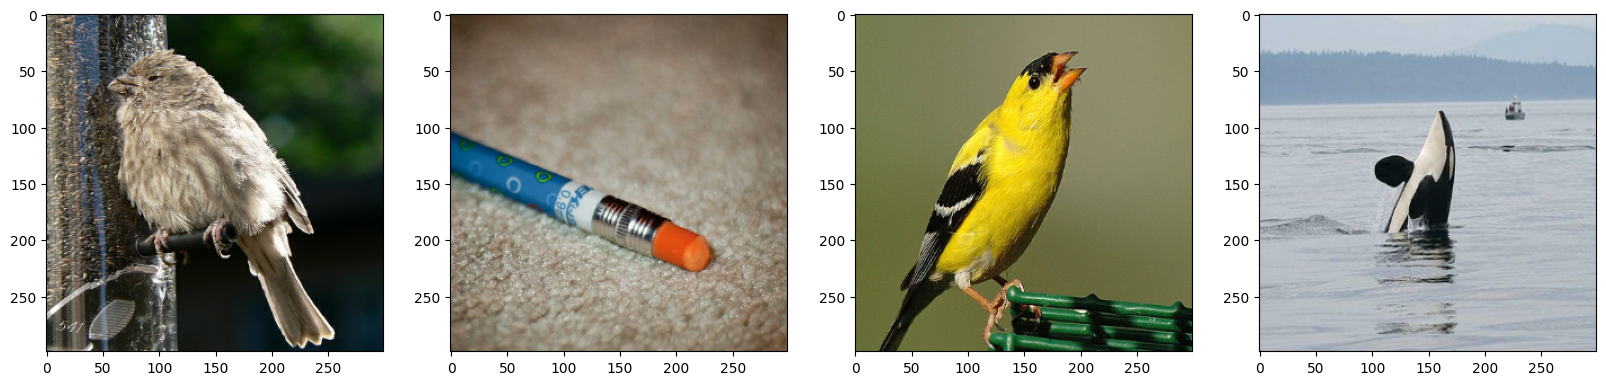

In [4]:
# Plot all normalized images using utils function so the images look good
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i in range(images.shape[0]):
    axs[i].imshow(utils.normalize(images[i]))

<div style="font-size: 10px;">

```python
# You can use the following pattern to plot your attribution results for all images:

fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5)) 

for i, image in enumerate(images):

    # Convert your numpy image to a PyTorch tensor of shape (1, C, H, W)
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

    # The target class label for the corresponding image
    target_class = int(labels[i])
   
    # Your function or library call here to compute the saliency map
    #-----------------------------------------------------------------

    saliency_map = your_attribution_method(model, target_label)

    #-----------------------------------------------------------------

    # Turn into numpy array and detach if necessary

    # Average over color channels if necessary

    # plot original image if necessary and saliency_map
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(utils.normalize(saliency_map), cmap='some color map', alpha=0.3)
```
</div>

### 1. Vanilla Gradients 

Over here I have curated a simple example of how gradients are calculated in PyTorch. Please carefully read through the code.

In [ ]:
def vanilla_gradients(model, input_tensor, target_class):
    """
    Calculates Vanilla Gradients (also known as Saliency Maps).

    Args:
        --> model: Your pre-trained PyTorch model.
        --> input_tensor: The image you want to explain (as a PyTorch tensor). In our case one of the four images.
        --> target_class: The class you want to explain (e.g., the index for "cat"). In our case the associated label.

    Returns:
        --> A NumPy array containing the raw gradients of each pixel.
    """

    # This is a very important command in PyTorch.
    # It tells the model, "We are now testing, not training."
    # This disables certain layers like Dropout that behave differently
    # during training and testing, ensuring our results are consistent
    # and reflect how the model actually makes predictions.
    model.eval()

    # Here we tell PyTorch to "Keep track of every calculation that involves this input_tensor.
    # Since we will need to calculate gradients with respect to it later.
    # Without this line, PyTorch wouldn't store the necessary information to compute the gradients.
    input_tensor.requires_grad_(True)

    # This is a standard prediction step.
    # We pass our image through the model to get the output.
    # The output is a list of scores for all possible classes (e.g., 1000 scores for ImageNet).
    # The if statement is just a safety check because some models (like InceptionV3) return a tuple of outputs,
    # and we only want the main prediction scores.
    output = model(input_tensor)
    if isinstance(output, tuple):
        output = output[0]  # Shape (1, num_classes)

    # From the 1000 scores in output, we only care about one:
    # the score for our target_class (e.g., "whale"). This line plucks out that single number.
    #  output[0, ...] is used because our input_tensor has a batch dimension of 1
    # so we select the first (and only) item in the batch.
    score = output[
        0, target_class
    ]  # Shape (1,) this is a logit? Is this number bound? WHy do we make this choice?

    # It's good practice to clear any old, leftover gradients. Think of it as erasing a chalkboard before a new calculation.
    model.zero_grad()

    # This single command is the heart of PyTorch's automatic differentiation.
    # It triggers the backpropagation algorithm. It calculates the gradient of
    # our score with respect to every single tensor in the computation graph that
    # has requires_grad=True set. Since we set it on our input_tensor, PyTorch calculates
    # the gradient of the 'whale' score with respect to every pixel in the input image.
    score.backward()

    # After score.backward() runs, PyTorch automatically populates the .grad attribute
    # of our input tensor with the gradients we just calculated.
    gradients = input_tensor.grad.clone()

    # This is a standard cleanup chain to make the result usable outside of PyTorch:
    saliency_map = gradients.cpu().detach().numpy()

    return saliency_map

Apply the above function to each image in our four image dataset

(1, 3, 299, 299)
(1, 3, 299, 299)
(1, 3, 299, 299)
(1, 3, 299, 299)


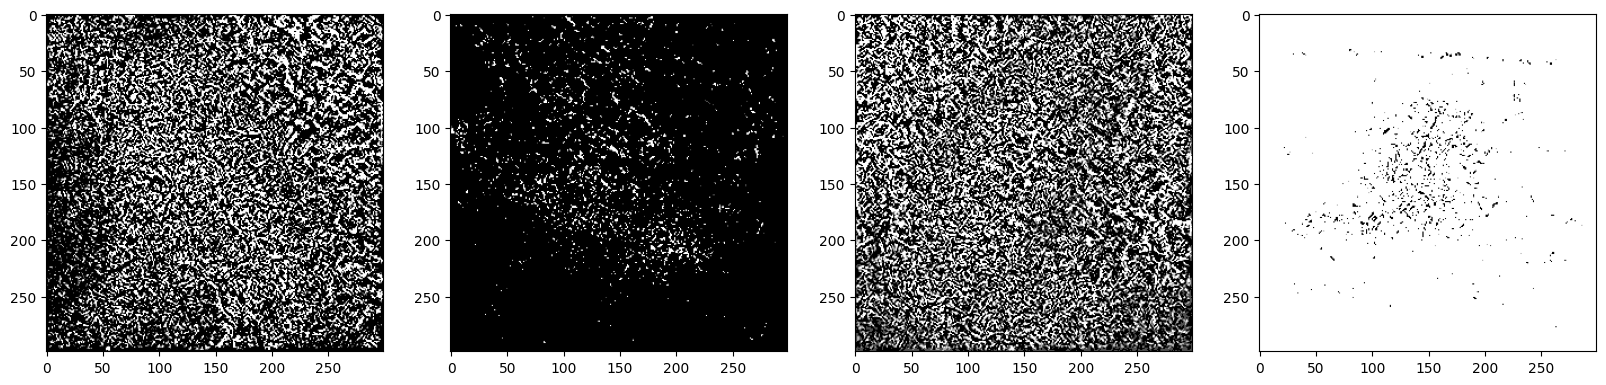

In [8]:
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Vanilla Gradients saliency map
    saliency_map = vanilla_gradients(model, input_tensor, target_class).squeeze()
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

Can you explain why it is so noisy?

Because of gradient saturation. Where certain activation functions can cause gradients to become small and get overshadowed by irrelevant gradients.

### 2. Turn vanilla gradients into Gradient x Input

Vanilla gradients tell us which pixels are sensitive, but not how much each pixel actually contributes. To get a first-order approximation of a pixel's importance, we multiply the pixel's sensitivity by its actual magnitude. This gives us an estimate of how much it affects the output. In the following code, inside the for loop, implement Gradient × Input.

(1, 3, 299, 299)
(1, 3, 299, 299)
(1, 3, 299, 299)
(1, 3, 299, 299)


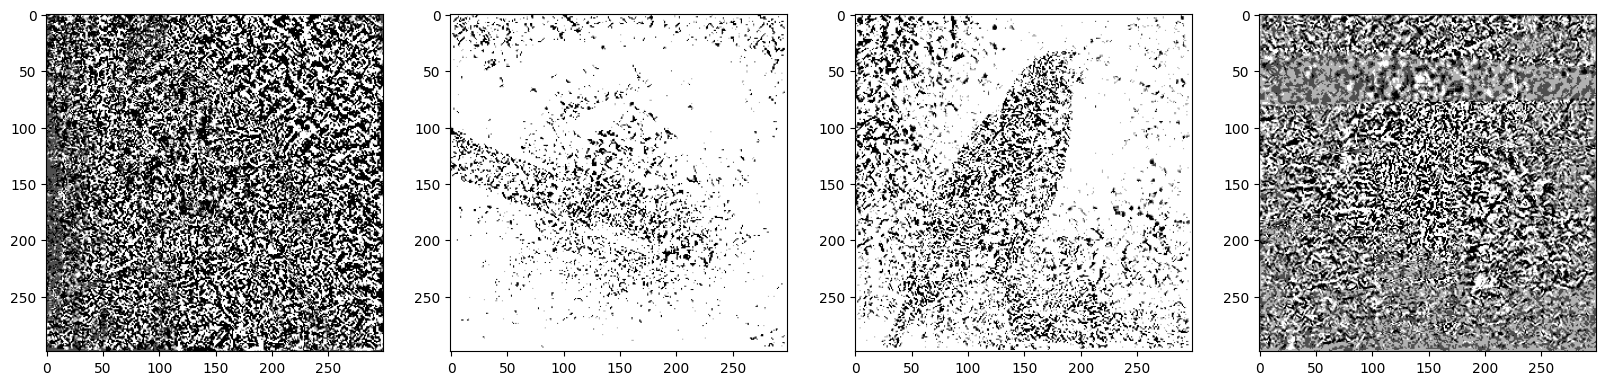

In [10]:
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Gradient x Input saliency map

    saliency_map = (
        input_tensor.cpu().detach().numpy().squeeze()
        * vanilla_gradients(model, input_tensor, target_class).squeeze()
    )

    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

<details>
  <summary>⚠️ Click here for the solution (this will use your "solution pass")</summary>
  
  ```python
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Gradients x Input saliency map
    grads = vanilla_gradients(model, input_tensor, target_class).squeeze()
    # Here is where we turn vanilla gradients into gradient x input
    saliency_map = grads * input_tensor.squeeze().cpu().detach().numpy() # get rid of batch dimension, make numpy
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map 
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

### 3. Turn Gradient x Input into Integrated Gradients  
Gradient x Input assumes a strong baseline (0) and is still noisy. You will not use your theoretical knowledge to write a function for Integrated gradients.

In [11]:
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    # Step 1: Set up the "Path" from Baseline to Input
    # If no baseline is provided, create a tensor of zeros with the same shape
    # as our input. For an image, this is like starting with a black image.
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    # Create the sequence of interpolated inputs. This is our "path".
    # We generate a series of images that gradually transition from the black
    # baseline image to the final input image.
    # The alpha term in our equation can be written as (float(i) / steps) and creates a fraction from 0.0 to 1.0.
    # At i=0, scaled_input = baseline.
    # At i=steps, scaled_input = input_tensor.
    # You might want to test your code by plotting these scaled_inputs to ensure they transition correctly.
    # Remember to set requires_grad=True so we can compute gradients with respect to these tensors later.
    scaled_inputs = [
        (baseline + (float(i) / steps) * (input_tensor - baseline)).requires_grad_(True)
        for i in range(steps + 1)
    ]

    # Step 2: Calculate Gradients at each Step Along the Path
    # Store the gradients we collect at each step.
    grads = []
    for scaled_input in scaled_inputs:
        # Essential step: clear any previous gradients.
        model.zero_grad()
        output = model(scaled_input)
        score = output[0, target_class]
        score.backward()
        gradients = scaled_input.grad.clone()
        grads.append(gradients.cpu().detach().numpy())

    # Step 3: Integrate the Gradients to Get Final Attributions
    # The list of gradients is converted to a single NumPy array for easy calculation.
    grads = np.array(grads)

    # To approximate the integral (the "summing up" part), we use the Trapezoidal rule.
    # It's a more accurate way of averaging the gradients along the path than a simple mean.
    # It works by averaging the gradients of adjacent pairs of steps.
    # grads[:-1] is all gradients except the last one.
    # grads[1:] is all gradients except the first one.
    # This aligns them so we can average step 0 with 1, 1 with 2, etc.
    avg_grads = (grads[:-1] + grads[1:]) / 2.0

    # Take the average of these trapezoidal-approximated gradients across all steps.
    # This gives us our final "average sensitivity" across the whole path.
    average_gradients = np.mean(avg_grads, axis=0)

    # Step 4: The core IG formula: Attribution = (Input - Baseline) * Integrated_Gradient
    # We multiply the difference between our original image and the baseline
    # by the average gradients we just calculated. This scales the attributions appropriately.
    integrated_grads = (
        input_tensor.cpu().detach().numpy() - baseline.cpu().detach().numpy()
    ) * average_gradients

    return integrated_grads

<details>
  <summary>⚠️ Click here for the solution (this will use your "solution pass")</summary>
  
  ```python
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    
    # Step 1: Set up the "Path" from Baseline to Input
    # If no baseline is provided, create a tensor of zeros with the same shape
    # as our input. For an image, this is like starting with a black image.
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Create the sequence of interpolated inputs. This is our "path".
    # We generate a series of images that gradually transition from the black
    # baseline image to the final input image.
    # The alpha term in our equation can be written as (float(i) / steps) and creates a fraction from 0.0 to 1.0.
    # At i=0, scaled_input = baseline.
    # At i=steps, scaled_input = input_tensor.
    # You might want to test your code by plotting these scaled_inputs to ensure they transition correctly.
    scaled_inputs = [
        (baseline + (float(i) / steps) * (input_tensor - baseline)).requires_grad_(True) 
        for i in range(0, steps + 1)
    ]


    # Step 2: Calculate Gradients at each Step Along the Path
    # Store the gradients we collect at each step.
    grads = []
    for scaled_input in scaled_inputs:
        # Essential step: clear any previous gradients.
        model.zero_grad()
        
        # Get the model's prediction for the current interpolated input.
        output = model(scaled_input)
        
        # We are interested in the score for our specific target class.
        # This score is what we will measure the sensitivity (gradient) of.
        # We extract the logit/score for our target class.
        score_for_target_class = output[0, target_class]
        
        # Calculate the gradients of the target class score with respect to the input pixels.
        # This tells us: "For this specific step, which pixels would I need to change
        # to increase the 'cat' score the most?"
        score_for_target_class.backward()
        
        # .grad contains the calculated gradients.
        # .detach() prevents PyTorch from tracking this operation further.
        # .cpu().numpy() moves the data to the CPU and converts it to a NumPy array.
        grads.append(scaled_input.grad.detach().cpu().numpy())
        

    # Step 3: Integrate the Gradients to Get Final Attributions
    # The list of gradients is converted to a single NumPy array for easy calculation.
    grads = np.array(grads)
    
    # To approximate the integral (the "summing up" part), we use the Trapezoidal rule.
    # It's a more accurate way of averaging the gradients along the path than a simple mean.
    # It works by averaging the gradients of adjacent pairs of steps.
    # grads[:-1] is all gradients except the last one.
    # grads[1:] is all gradients except the first one.
    # This aligns them so we can average step 0 with 1, 1 with 2, etc.
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    
    # Take the average of these trapezoidal-approximated gradients across all steps.
    # This gives us our final "average sensitivity" across the whole path.
    average_gradients = np.mean(avg_grads, axis=0)


    # Step 4: The core IG formula: Attribution = (Input - Baseline) * Integrated_Gradient
    # We multiply the difference between our original image and the baseline
    # by the average gradients we just calculated. This scales the attributions appropriately.
    integrated_grads = (input_tensor.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * average_gradients

    return integrated_grads

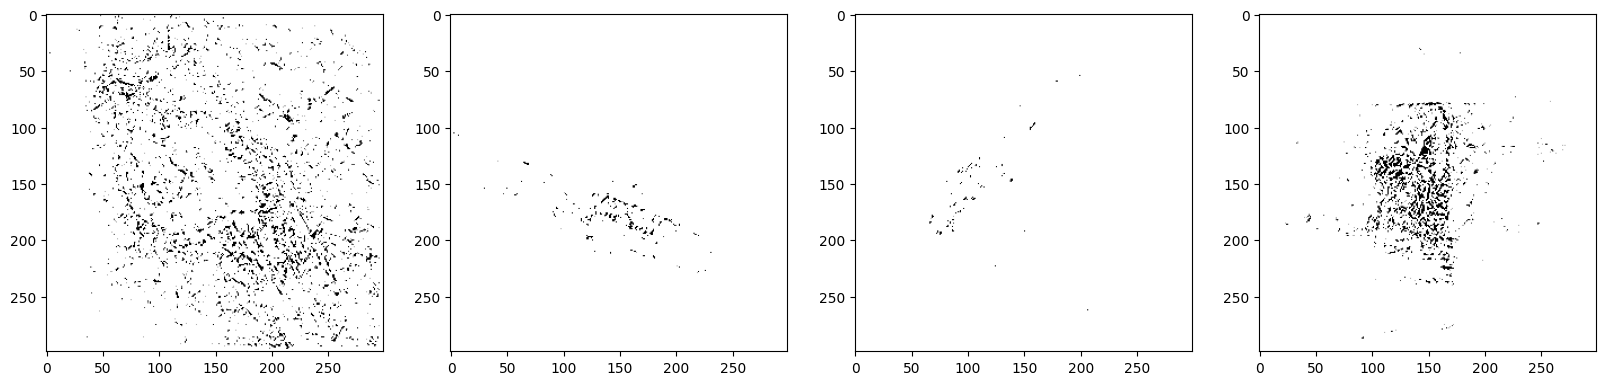

In [12]:
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Integrated Gradients saliency map
    saliency_map = integrated_gradients(model, input_tensor, target_class).squeeze()
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

### 4. Change the baseline and comment on the results

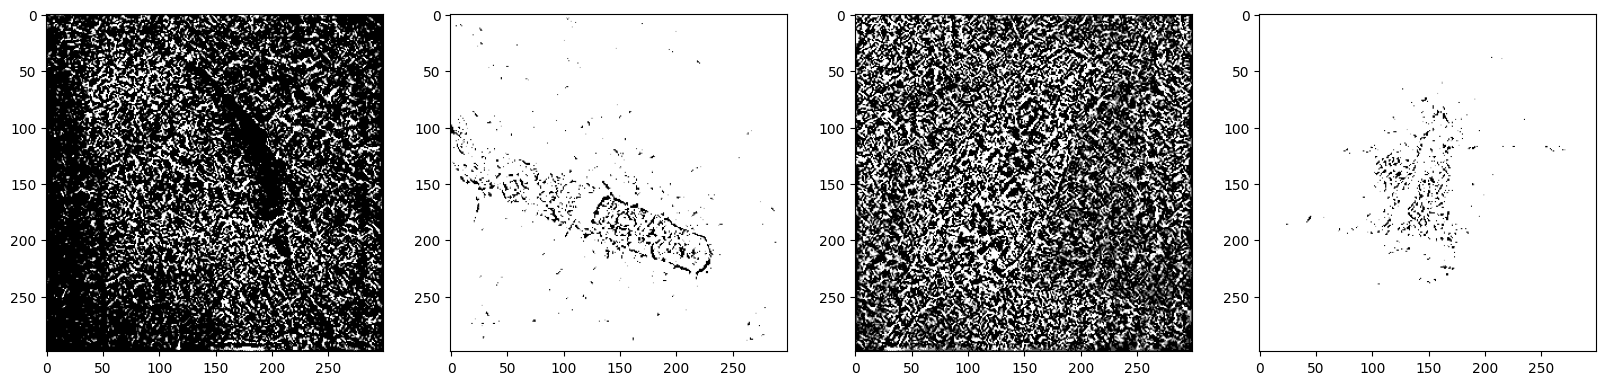

In [13]:
# Use a different baseline of all ones
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Integrated Gradients saliency map
    saliency_map = integrated_gradients(
        model, input_tensor, target_class, baseline=torch.ones_like(input_tensor)
    ).squeeze()
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

### 5. Compare your results by implementing Captum's IntegratedGradients method

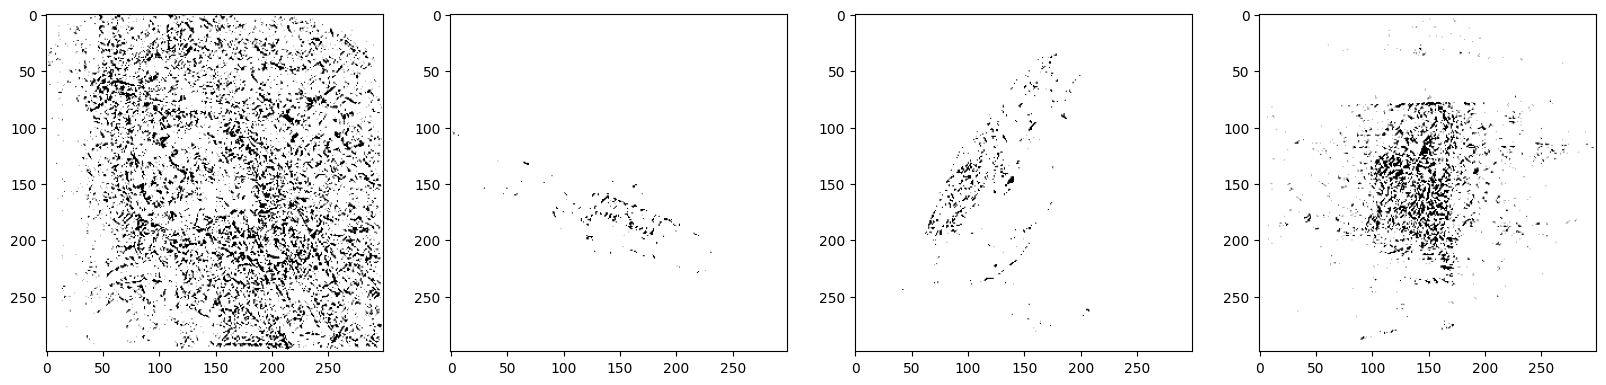

In [14]:
# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Plot Integrated Gradients reults from Captum library for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert your numpy image to a PyTorch tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])
    # Compute Integrated Gradients saliency map
    saliency_map = (
        ig.attribute(input_tensor, target=target_class).squeeze().detach().numpy()
    )
    # avarage over color channels
    saliency_map = np.mean(saliency_map, axis=0)
    # Plot integrated gradients saliency map
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=1)

### 6. List some benefits and downsides of Integrated Gradients

<details>
  <summary>⚠️ Click here for the solution (this will use your "solution pass")</summary>

Benifits
+ Better baseline handling: Gradient × Input assumes a baseline of all zeros (black image). IG generalizes this: you choose a baseline (e.g., black image, blurred image, average image) and integrate the gradients along the straight path from baseline to input. This makes attributions less sensitive to arbitrary pixel values. 
+ Completeness property: The attributions add up (approximately) to the difference in output between the input and baseline. This gives a principled way to explain the model's decision. 
+ Noise reduction: By averaging gradients along many steps, IG smooths out the noise you often see in vanilla gradients. 
+ Handles saturation In ReLU networks: once activations saturate (flat regions), vanilla gradients can go to zero even if the feature was important. IG samples across the path, so it can capture the contribution before saturation.  

Downsides
- Choice of baseline: What is the “absence of signal” for an image? Black (all zeros)? Blurred? Mean of dataset? Different baselines can produce different attributions as you have seen. 
- Computational cost: You need many gradient evaluations (say, 50–200) per input to approximate the integral. This is more expensive than vanilla gradients or Gradient × Input (which only need one backward pass). 
- Still local and path-dependent: IG assumes a straight-line path from baseline to input. If the model behaves nonlinearly along other paths, IG might miss interactions. 

